In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from pca import pca
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

# Data Exploration 

In [2]:
# Read data 'UsArrests.csv' into dataframe
df = pd.read_csv('UsArrests.csv')
df.head() # Show first 5 rows

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
df.info() # Show info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [4]:
# Convert all numerical features into float
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')
df.info() # Check conversion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
# Check for missing values
df.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [6]:
# Get prelimnary statistics about data
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


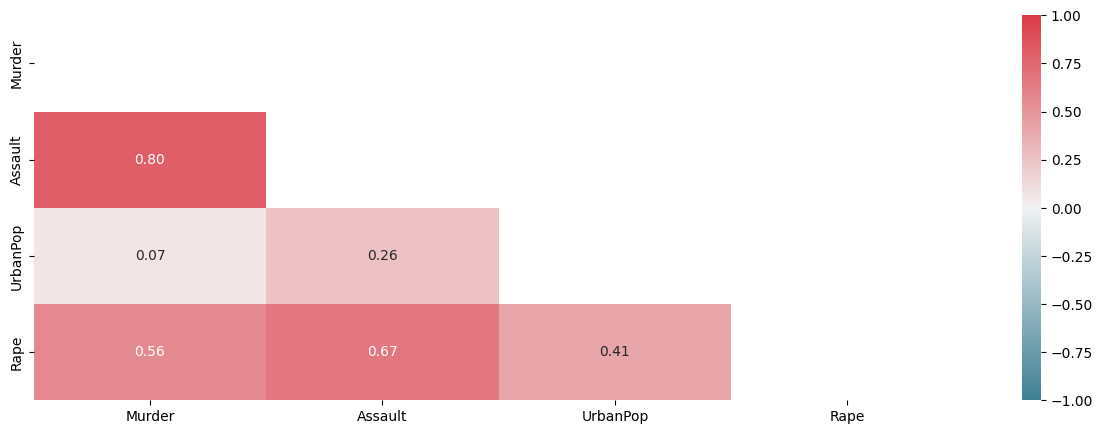

In [7]:
# Define function to create heatmap
def heatmap(df):

    # Define colormap of heatmap
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    # Set figure size
    plt.figure(figsize=(15,5))

    # Define mask by setting upper right triangle values to True
    mask = np.triu(np.ones_like(df.corr(),dtype=bool))

    # Plot correlation heatmap
    sns.heatmap(df.corr(), mask=mask, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap=colormap)
    plt.show()

# Use heatmap() on df
heatmap(df)

The 3 highest correlations between:
- Assault + Murder (0.8)
- Assault + Rape (0.67)
- Murder + Rape (0.56)

The 3 lowest correlations are all of those involving UrbanPop.

Therefore, the principal components created later will mostly incorporate UrbanPop and remove redundancies between Assault, Murder, and Rape.

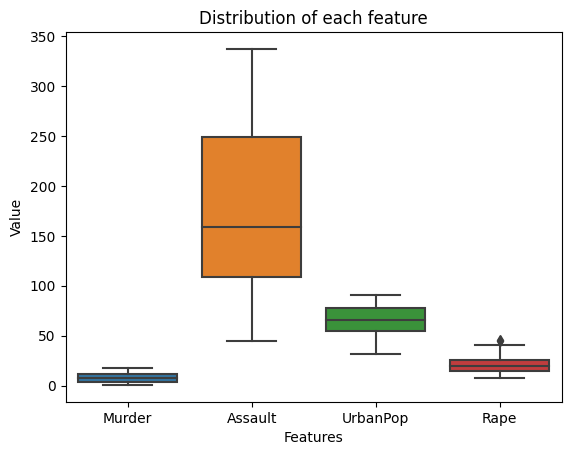

In [8]:
# Use boxplot to show distribution of each feature
sns.boxplot(data=df)
plt.ylabel('Value') # Set y-axis label
plt.xlabel('Features') # Set x-axis label
plt.title('Distribution of each feature') # Set title
plt.show()

# Data Scaling

Make all features have a normal distribution in order to perform PCA on them accurately. Use StandardScaler.

In [9]:
# Scale data using StandardScaler()
scaled = StandardScaler().fit_transform(df.iloc[:,1:])

# Convert scaled data into a dataframe
df_scale = pd.DataFrame(scaled,columns = df.columns[1:])
df_scale.head() # Show first 5 rows

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


# Determining number of PCA components

In [10]:
# Use PCA to get all prinicipal components of data
pca1 = PCA().fit(df_scale)

# Show explained variance of each component
pca1.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

We want the variance explained by all components to be at least 80%. Let's plot a graph of the cumulative explained variance to see minimum number of components to reach the 80% threshold.

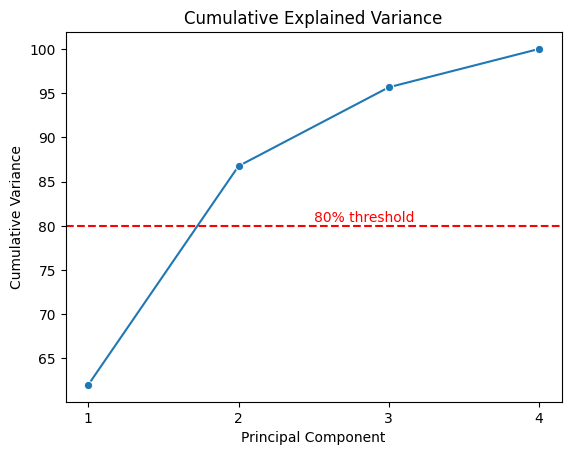

In [11]:
# Create dictionary containing values to be plotted
# x values 1-5 made using np.arange(), y values of cumulative varaince made using np.cumsum()
d = {'PC' : np.arange(1,5), 'Var' : np.cumsum(pca1.explained_variance_ratio_)*100}

# Convert dictionary into dataframe
var_df = pd.DataFrame(d)

# Plot lineplot
sns.lineplot(data=var_df, x='PC', y='Var', marker='o')
plt.axhline(y=80, color='r', linestyle='--') # Plot threshold line
plt.text(2.5, 80.5, '80% threshold', color='red') # Create text for threshold
plt.xlabel('Principal Component') # Set x-label
plt.ylabel('Cumulative Variance') # Set y-label
plt.xticks(np.arange(1,5)) # Set x-ticks
plt.title('Cumulative Explained Variance') # Set title
plt.show()


80% cumulative explained variance is reached at 2 principal components, we will use 2 components for PCA.

In [12]:
# Set number of components in PCA as 2
nr_comps = 2
pca2 = PCA(n_components=nr_comps)

# Perform PCA on scaled data
pca_array = pca2.fit_transform(df_scale)
pca_array.shape # Check shape to see if there are 2 components

(50, 2)

# PCA Exploration

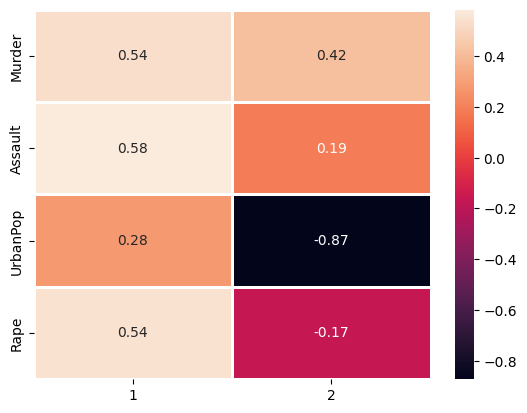

In [13]:
# Get components_ of the PCA and convert to dataframe
components = pd.DataFrame(pca2.components_, columns=df.columns.drop('City'), index=range(1, nr_comps+1)).transpose()

# Plot heatmap of the components dataframe
ax = sns.heatmap(components,linewidth=1,annot=True,fmt=".2f")
plt.show()

Heatmap shows correlation of each feature with the 2 principal components.

- The first component is slightly correlated with Murder, Assault, and Rape, with correlations of 0.54, 0.58, and 0.54
- The second component is mainly consisting of UrbanPop, with a highly negative correlation of -0.87

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


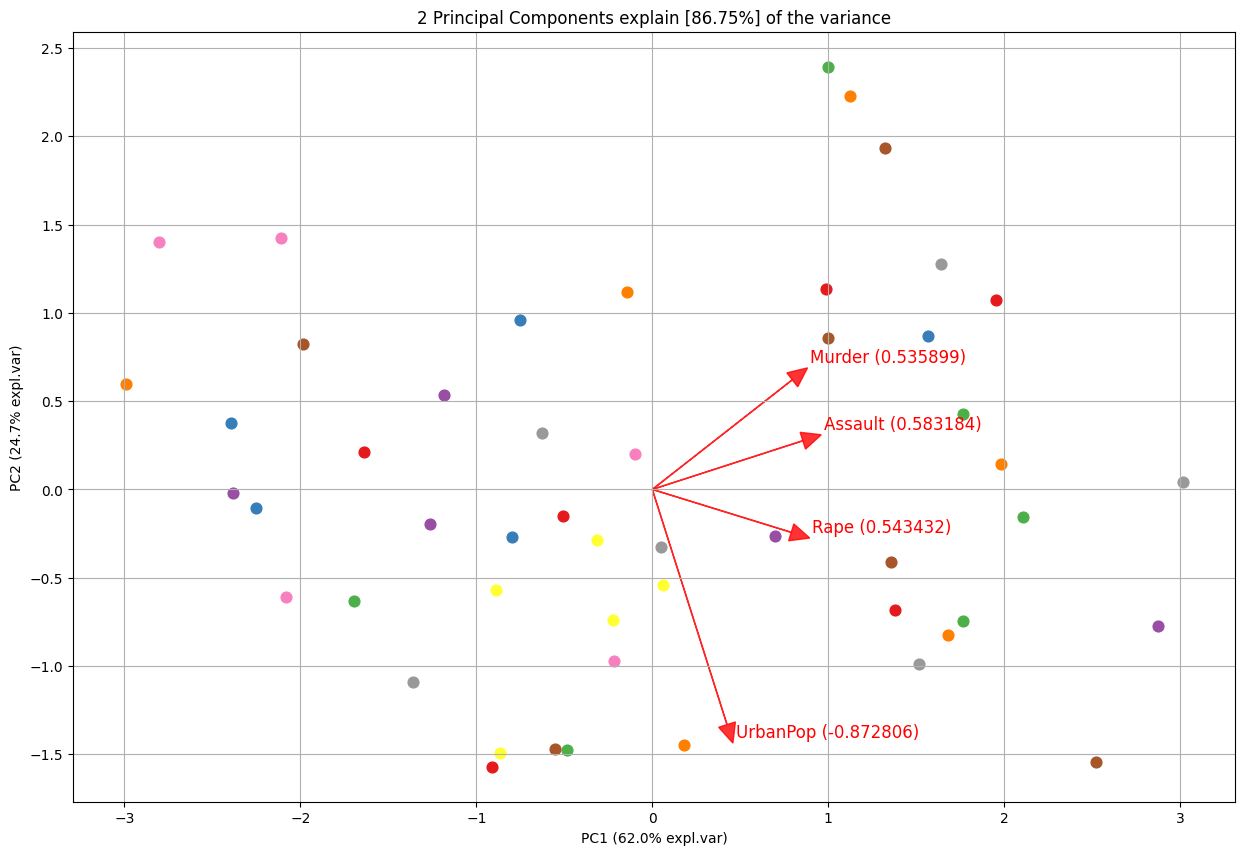

In [14]:
# Use pca() from pca to create PCA algorithm with 2 principal components
model = pca(n_components=2)

# Fit algorithm on df_scale 
results = model.fit_transform(df_scale)

# Create biplot of PC2 against PC1
model.biplot(n_feat=4, legend=False, label=False)
plt.show()

The vectors show each feature's correlation with the principal components, which matches that of the correlation heatmap above.

- Murder, Assault, and Rape are correlated with PC1
- UrbanPop is highly negatively correlated with PC2

The data points show the PC1 and PC2 values of each city.

Now let's create a dataframe for clustering analyses using these 2 components:

In [15]:
# Create dataframe using pca_array
pca_df = pd.DataFrame(pca_array, columns=['PC1','PC2'])

# Create 'City' column with the original df
pca_df.index = df['City']
pca_df.head() # Show first 5 rows

,PC1,PC2
City,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


# Hierarchical Clustering


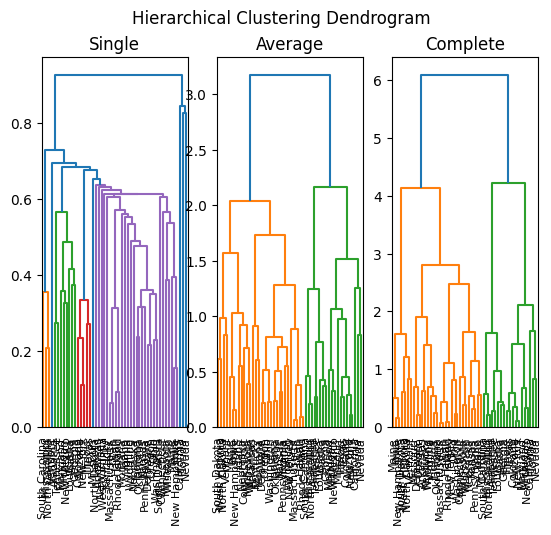

In [16]:
# Create algorithm using AgglomerativeClustering()
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Fit algorithm onto pca_df
model = model.fit(pca_df)

# Create plots comparing 3 different linkage methods
fig, (ax1, ax2, ax3) = plt.subplots(1, 3) # Create 3 subplots
fig.suptitle('Hierarchical Clustering Dendrogram') # Set suptitle

# Plot dendrogram with 'single' linkage
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1)
ax1.set_title("Single") # Set title of plot 1

# Plot dendrogram with 'average' linkage
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax2.set_title("Average") # Set title of plot 2


# Plot dendrogram with 'complete' linkage
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
ax3.set_title("Complete") # Set title of plot 3
plt.show()

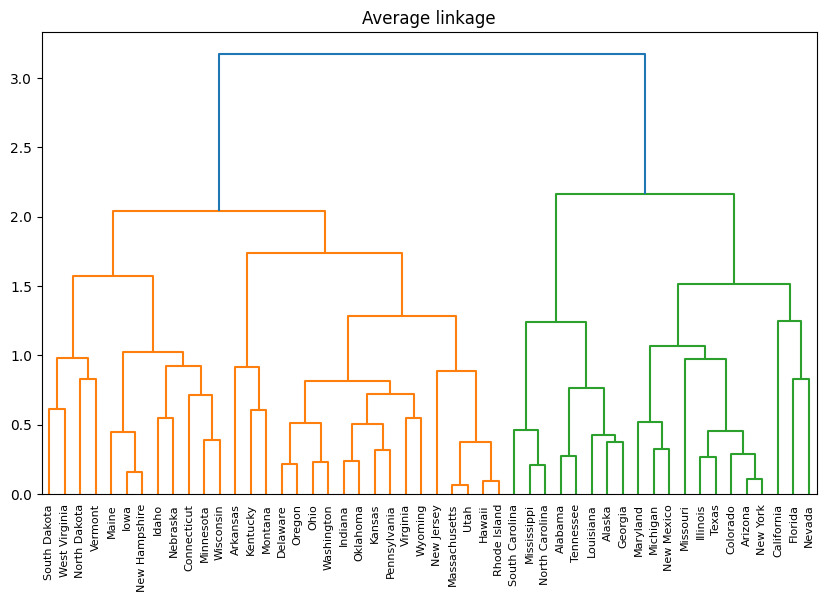

In [17]:
# Choose 'average' linkage as it looks the best, plot bigger version:
plt.figure(figsize=(10,6)) # Set figure size
plt.title("Average linkage") # Set figure title
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index) # Create dendrogram
plt.show()

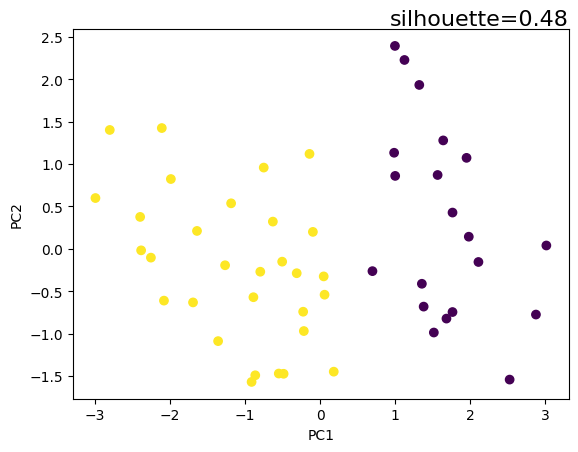

In [18]:
# Create cluster using 'average' linkage
cluster = AgglomerativeClustering(n_clusters=2, linkage='average')

# Fit onto pca_df
cluster.fit_predict(pca_df)

# Work out silhouette score
score = round(silhouette_score(pca_df, cluster.labels_),2)

# Plot cluster plot showing the 2 clusters
plt.scatter(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], c=cluster.labels_)
plt.xlabel('PC1') # Set x-label
plt.ylabel('PC2') # Set y-label

# Show silhouette score
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
plt.show()

- Silhouette score of 0.48 is not bad - shows clustering is successful
- The clusters seem to only be separated based on PC1 values - the divide is just vertical on the plot

# KMeans Clustering

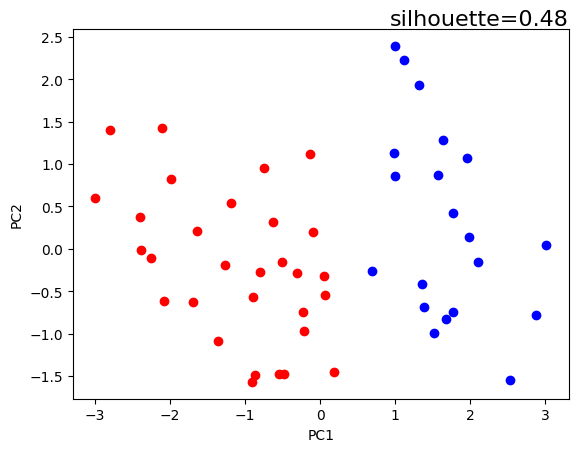

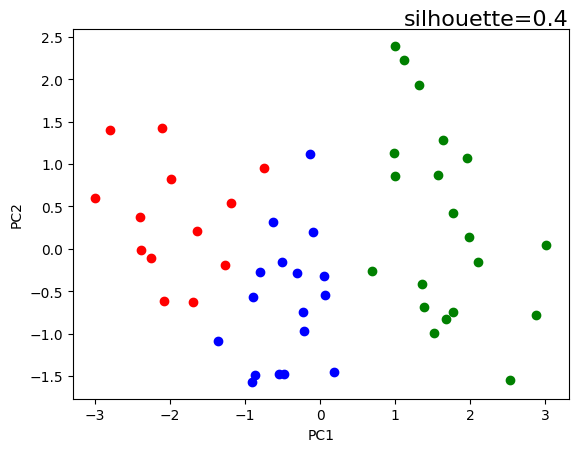

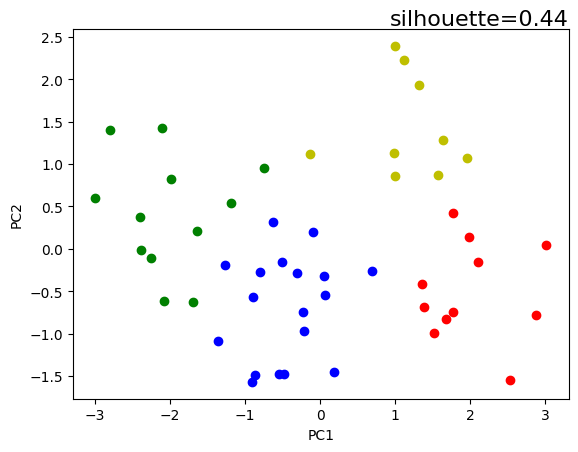

In [33]:
# Create 3 Kmeans clustering plots, with k = 2, 3, and 4
x = pca_df.iloc[:,0] # Define x values
y = pca_df.iloc[:,1] # Define y values
colours = 'rbgy' # Define colours for clusters

# Use for loop to iterate through 2-4
for k in range(2,5):

    # Use KMeans, set n_clusters = k
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    cluster_labels = kmeans.fit_predict(pca_df) # Fit model
    score = round(silhouette_score(pca_df, kmeans.labels_),2) # Work out score
    
    # Plot clusters
    fig, ax = plt.subplots()

    # Use for loop to iterate through 0 to k
    for i in range(0,k):
        # Use cluster_labels to get the index of x and y values of the same cluster, set colour
        ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

    # Set title as silhouette score
    ax.set_title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    ax.set_xlabel("PC1") # Set x-label
    ax.set_ylabel("PC2") # Set y-label

The number of clusters with the best score is k = 2 (0.48). The clusters match exactly with the hierarchical cluster, showing again that the cluster division is just based on PC1 values.

Let's see which countries are in which cluster:

In [66]:
# Create KMeans clustering algorithm with n_clusters as 2
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
cluster_labels = kmeans.fit_predict(pca_df) # Fit onto pca_df

# Get index numbers of each group
group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]

# Create arrays containing the cities of each group, using index numbers and pca_df.index
group0 = np.array(pca_df.index)[group0_indices]
group1 = np.array(pca_df.index)[group1_indices]

# Print the 2 groups
print("Group 0: {}\n\n".format([x for x in group0]))
print("Group 1: {}".format([x for x in group1]))


Group 0: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


Group 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']
